<p align="center"><img alt="udeA logo" height="150px" src="https://github.com/freddyduitama/images/blob/master/logo.png?raw=true"></p><h1><font color='0B5345'> <center>

Probabilidad y estadística

 </center></font></h1>
<h2><font color='0B5345'> <center>
Tercer Proyecto: Aprendizaje Supervisado</center></font></h2>
<font  face="Courier New" size="3">

<p3><center><b><font color='0B5345' face="Lucida Calligraphy,Comic Sans MS,Lucida Console" size="5">Universidad de Antioquia - Bioingeniería</font></b> </center></p3>

### **MODELO DE CLASIFICACIÓN**

### **ANÁLISIS EXPLORATORIO DE DATOS**

In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [132]:
df_cancer = pd.read_csv('data_cancer.csv', sep=";")
df_cancer

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


Intercambiamos;

Benigno (B) = 0

Maligno (M) = 1

In [133]:
df_cancer.replace(regex=r'B', value=0, inplace=True)
df_cancer.replace(regex=r'M', value=1, inplace=True)

In [134]:
df_cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    int64  
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [135]:
df_cancer.describe().T

,count,mean,std,min,25%,50%,75%,max
id,569.0,3.037183e+07,1.250206e+08,8670.000000,869218.000000,906024.000000,8.813129e+06,9.113205e+08
diagnosis,569.0,3.725835e-01,4.839180e-01,0.000000,0.000000,0.000000,1.000000e+00,1.000000e+00
radius_mean,569.0,1.412729e+01,3.524049e+00,6.981000,11.700000,13.370000,1.578000e+01,2.811000e+01
texture_mean,569.0,1.928965e+01,4.301036e+00,9.710000,16.170000,18.840000,2.180000e+01,3.928000e+01
perimeter_mean,569.0,9.196903e+01,2.429898e+01,43.790000,75.170000,86.240000,1.041000e+02,1.885000e+02
area_mean,569.0,6.548891e+02,3.519141e+02,143.500000,420.300000,551.100000,7.827000e+02,2.501000e+03
smoothness_mean,569.0,9.636028e-02,1.406413e-02,0.052630,0.086370,0.095870,1.053000e-01,1.634000e-01
compactness_mean,569.0,1.043410e-01,5.281276e-02,0.019380,0.064920,0.092630,1.304000e-01,3.454000e-01
concavity_mean,569.0,8.879932e-02,7.971981e-02,0.000000,0.029560,0.061540,1.307000e-01,4.268000e-01
concave points_mean,569.0,4.891915e-02,3.880284e-02,0.000000,0.020310,0.033500,7.400000e-02,2.012000e-01


En una inspección rápida, notamos que existen datos con valores iguales a 0. Estos datos no pueden existir ya que expresan medidas de volumen.

In [136]:
for column in df_cancer.columns:
    zero_values = (df_cancer[column] == 0).sum()
    if zero_values != 0:
        print(column, zero_values)

diagnosis 357
concavity_mean 13
concave points_mean 13
concavity_se 13
concave points_se 13
concavity_worst 13
concave points_worst 13


Viendo la poca cantidad de datos, decidimos quitarlos del dataset. Diagnosis no va a ser afectado.

In [137]:
df_cancer = df_cancer[(df_cancer.drop('diagnosis', axis=1) != 0).all(axis=1)]
len(df_cancer)

556

**Visualización de datos**

Para facilitar la visualización de los datos aplicamos z-score a todas las columnas

In [138]:
df_cancer_z = df_cancer.drop(['diagnosis'], axis=1)
df_cancer_z = (df_cancer_z - df_cancer_z.mean()) / df_cancer_z.std()

Text(0, 0.5, 'Sin Z-score')

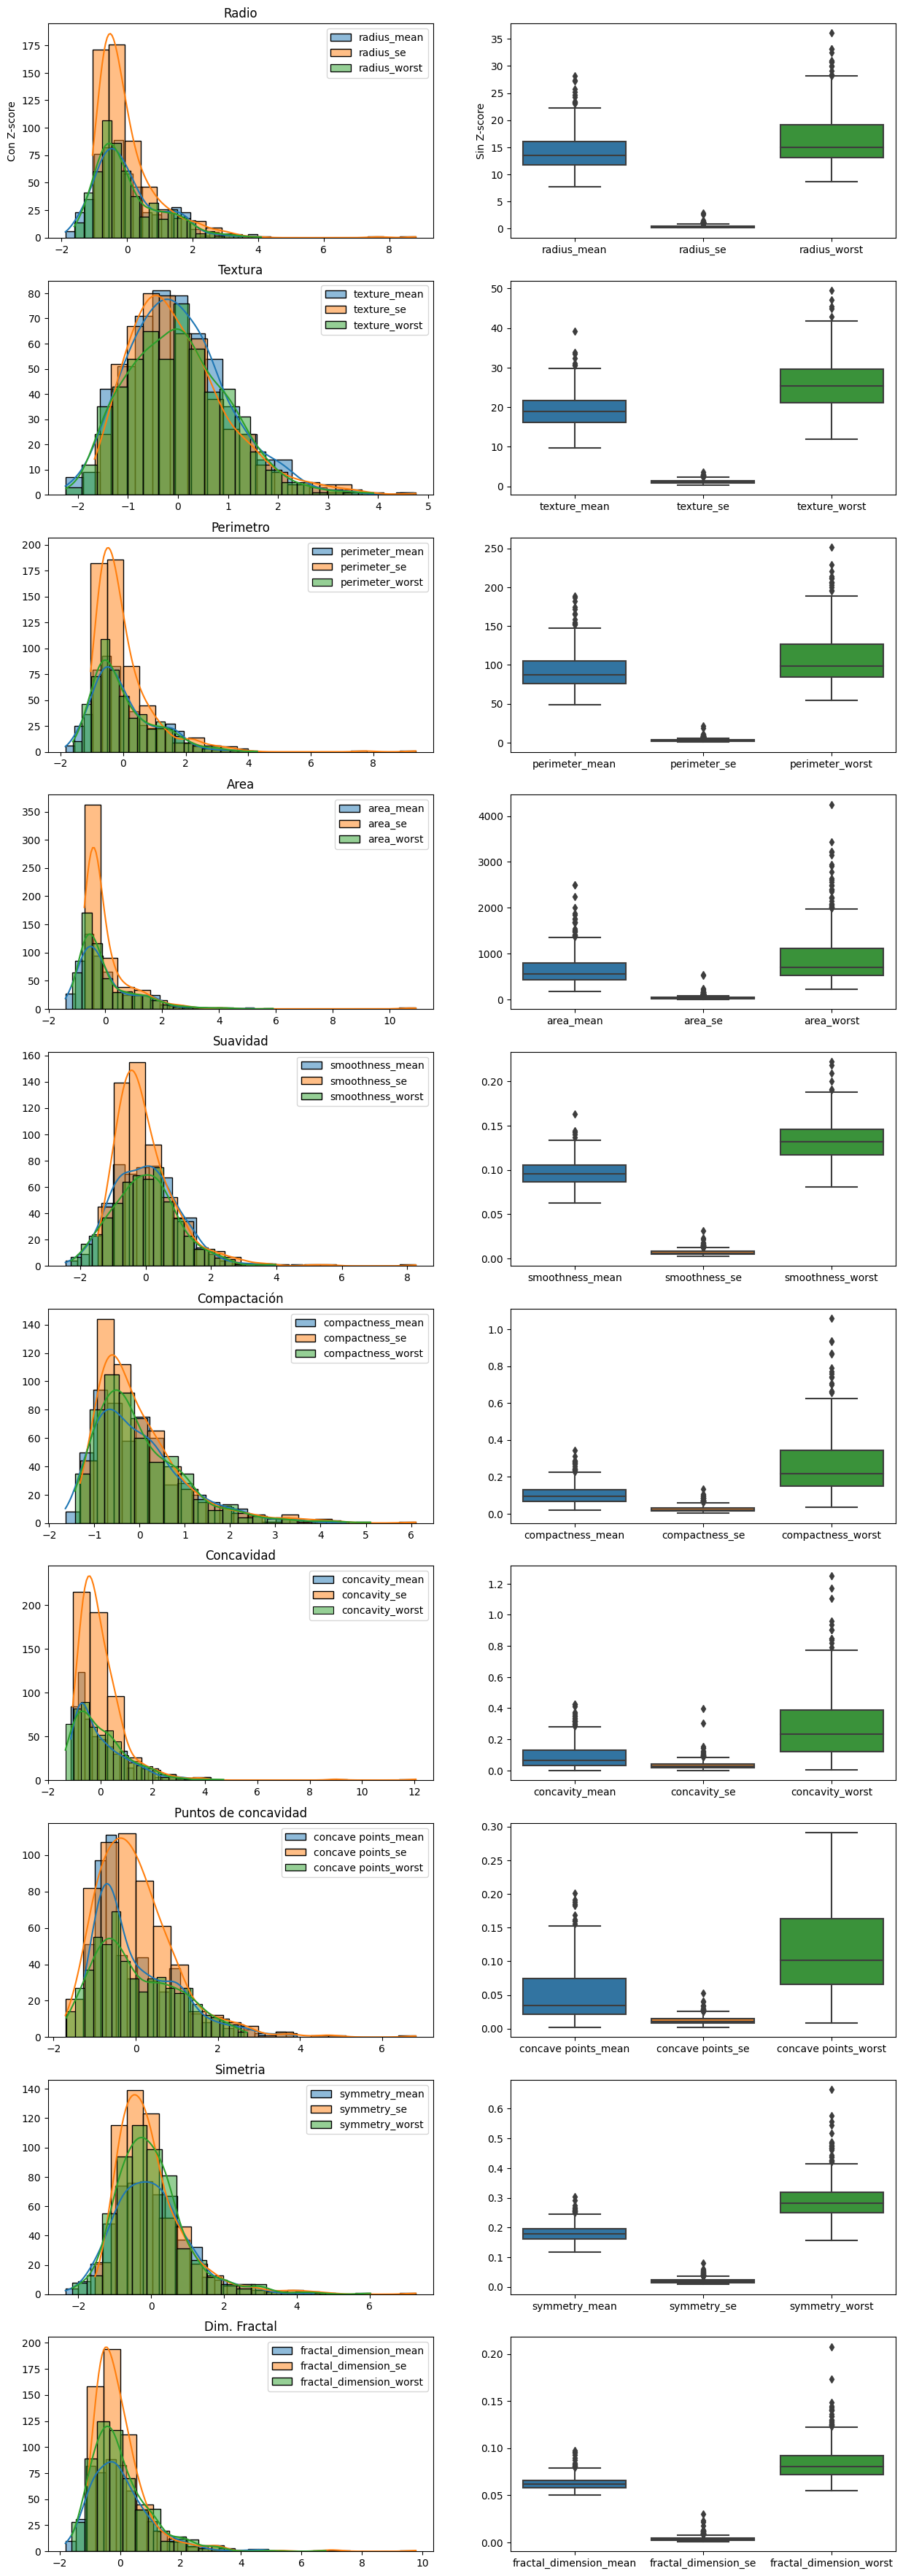

In [139]:
fig, axs = plt.subplots(10, 2, figsize=(15, 45))

# Histogramas

def hist_cancer(columna, ax1, name):
    for a in columna:
        sns.histplot(data=df_cancer_z, x=a, bins=20, kde=True, ax=ax1, label=a)
    ax1.legend()
    ax1.set_title(name)
    ax1.set_xlabel('')
    ax1.set_ylabel('')

radio = ['radius_mean', 'radius_se', 'radius_worst']
textura = ['texture_mean', 'texture_se', 'texture_worst']
perimetro = ['perimeter_mean', 'perimeter_se', 'perimeter_worst']
area = ['area_mean', 'area_se', 'area_worst']
suavidad = ['smoothness_mean', 'smoothness_se', 'smoothness_worst']
compactacion = ['compactness_mean', 'compactness_se', 'compactness_worst']
concavidad = ['concavity_mean', 'concavity_se', 'concavity_worst']
pts_concavidad = ['concave points_mean', 'concave points_se', 'concave points_worst']
simetria = ['symmetry_mean', 'symmetry_se', 'symmetry_worst']
dim_frac = ['fractal_dimension_mean', 'fractal_dimension_se', 'fractal_dimension_worst']

hist_cancer(radio, axs[0, 0], 'Radio')
hist_cancer(textura, axs[1, 0], 'Textura')
hist_cancer(perimetro, axs[2, 0], 'Perimetro')
hist_cancer(area, axs[3, 0], 'Area')
hist_cancer(suavidad, axs[4, 0], 'Suavidad')
hist_cancer(compactacion, axs[5, 0], 'Compactación')
hist_cancer(concavidad, axs[6, 0], 'Concavidad')
hist_cancer(pts_concavidad, axs[7, 0], 'Puntos de concavidad')
hist_cancer(simetria, axs[8, 0], 'Simetria')
hist_cancer(dim_frac, axs[9, 0], 'Dim. Fractal')

sns.boxplot(data=df_cancer[radio], ax=axs[0, 1])
sns.boxplot(data=df_cancer[textura], ax=axs[1, 1])
sns.boxplot(data=df_cancer[perimetro], ax=axs[2, 1])
sns.boxplot(data=df_cancer[area], ax=axs[3, 1])
sns.boxplot(data=df_cancer[suavidad], ax=axs[4, 1])
sns.boxplot(data=df_cancer[compactacion], ax=axs[5, 1])
sns.boxplot(data=df_cancer[concavidad], ax=axs[6, 1])
sns.boxplot(data=df_cancer[pts_concavidad], ax=axs[7, 1])
sns.boxplot(data=df_cancer[simetria], ax=axs[8, 1])
sns.boxplot(data=df_cancer[dim_frac], ax=axs[9, 1])

axs[0, 0].set_ylabel('Con Z-score')
axs[0, 1].set_ylabel('Sin Z-score')

**Remoción de datos atípicos**

In [140]:
def remove_outliers_iqr(data):
    
    # Calculate the first quartile (Q1) and third quartile (Q3)
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    
    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1
    
    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Remove outliers
    data = np.where(data>upper_bound, upper_bound, np.where(data<lower_bound,lower_bound,data))
    return data[(data >= lower_bound) & (data <= upper_bound)]

In [141]:
for i in df_cancer.columns:
    df_cancer[i] = remove_outliers_iqr(df_cancer[i])

C:\Users\Josue Paniagua Lopez\AppData\Local\Temp\ipykernel_25000\3338917969.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cancer[i] = remove_outliers_iqr(df_cancer[i])


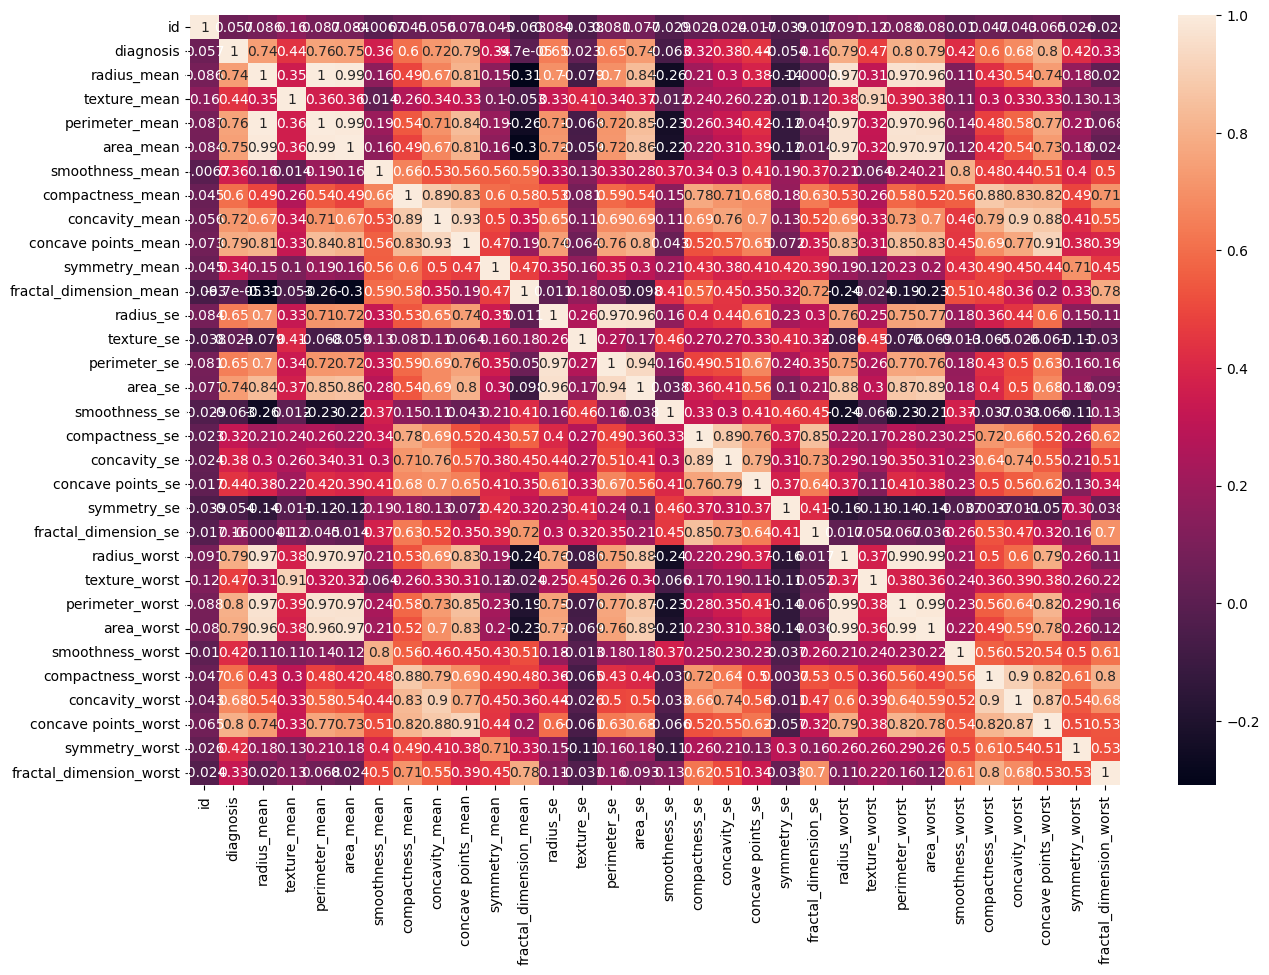

In [142]:
plt.figure(figsize=(15,10))
sns.heatmap(df_cancer.corr(),fmt='.2g',annot=True)
plt.show()

> Una primera observación a destacar es la fuerte correlación del radio, perímetro y área de la imagen, debido a que el área es la que aporta más información, elegimos las columnas relacionadas para nuestro modelo.


> El segundo aspecto a destacar son las correlaciones entre las medias de todos los datos y su peor valor registrado, si bien no tan significatico como el punto anterior, sigue teniendo una influencia significativa con valores de hasta 0.8. Se decidió por la media por aportar más información.

Así despues de una purga de columnas obtenemos:

In [143]:
df_cancer_test =  df_cancer[['diagnosis', 
                            'area_mean', 'area_se',
                            'smoothness_mean', 'smoothness_se',
                            'compactness_mean', 'compactness_se',
                            'concavity_mean', 'concavity_se',
                            'concave points_mean', 'concave points_se',
                            'symmetry_mean', 'symmetry_se',
                            'fractal_dimension_mean', 'fractal_dimension_se']]

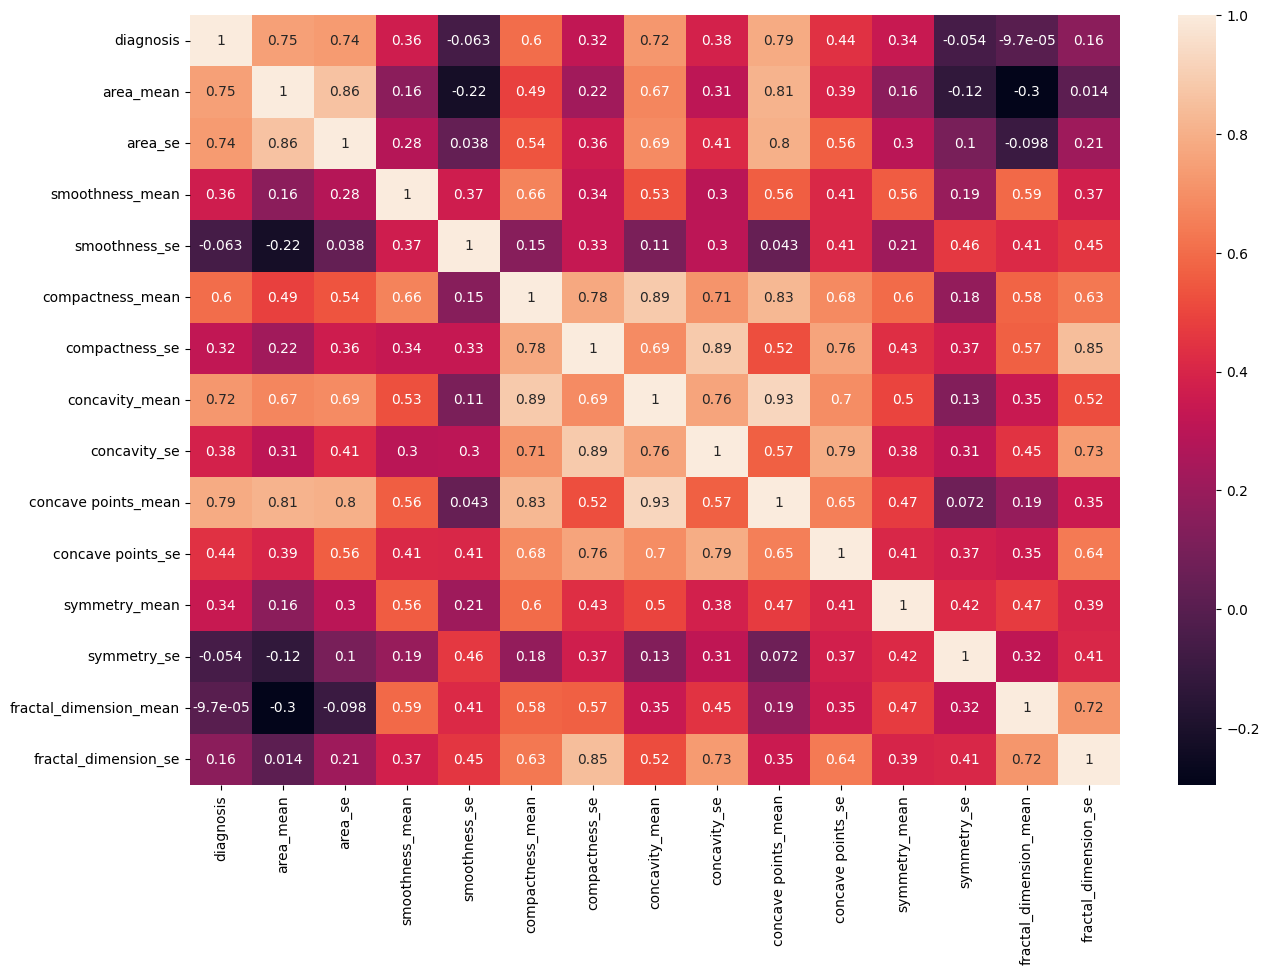

In [144]:
plt.figure(figsize=(15,10))
sns.heatmap(df_cancer_test.corr(),fmt='.2g',annot=True)
plt.show()

En este segundo análisis de datos; 

> notemos que la concavidad y los puntos de concavidad siguen fuertemente relacionados entre sí, elegimos los puntos de concavidad debido a que presenta una mayor correlación con el diagnóstico.

> Lo mismo sucede con la compactación, por este motivo se elige solo los puntos de concavidad.

> Además, por la poca correlación que ejerce la dimensión fractal, se decidió prescindir de esta columna.

In [145]:
df_cancer_test =  df_cancer[['diagnosis', 
                            'area_mean', 'area_se',
                            'smoothness_mean', 'smoothness_se',
                            'concave points_mean', 'concave points_se',
                            'symmetry_mean', 'symmetry_se']]

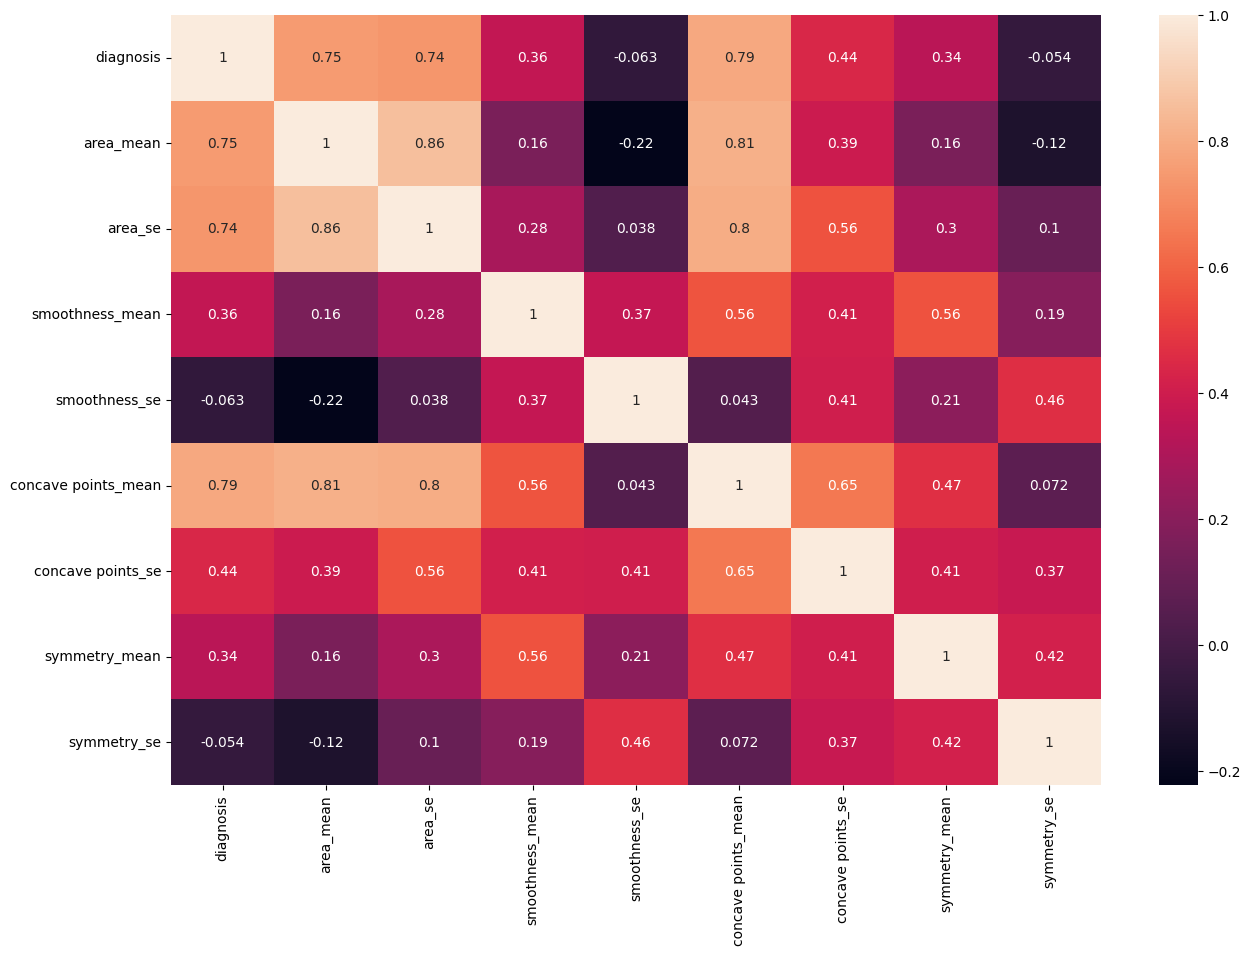

In [146]:
plt.figure(figsize=(15,10))
sns.heatmap(df_cancer_test.corr(),fmt='.2g',annot=True)
plt.show()

> Si bien se observa una alta correlación entre los puntos de concavidad y el area del tumor, no se eliminó ninguna de las columnas, debido a que aportan información distinta por lo que conceptualmente son independientes, además, el modelo funciona con un menor rendimiento si hace falta alguno de los dos.

### **Análisis del modelo**

**Variables**:

**Explicada (Y)**: 
- Diagnostico (tumor benigno o no maligno)

**Explicatorias (X)**: 
- Área media
- Error std. Área
- Suavidad media 
- Error std. Suavidad
- Puntos de concavidad media
- Error std. Puntos de concavidad
- Simetría media
- Error std. Simetría
- Dim. fractal media
- Error std. Dim fractal

**Importamos las librerias**

In [147]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

**Datos de entrenamiento**

In [148]:
x = df_cancer_test.drop(columns=['diagnosis']) # Explicatoria
y = df_cancer_test['diagnosis'] # Explicada

In [149]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

**Entrenamiento del modelo**

In [150]:
modelo = LogisticRegression(max_iter= 1000)
modelo.fit(x_train, y_train)

y_predi = modelo.predict(x_test)

**Matriz de confusión**

Text(0.5, 23.52222222222222, 'Valores reales')

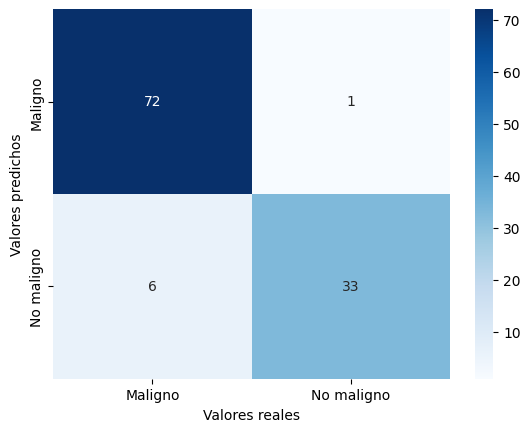

In [151]:
matriz_confusion = confusion_matrix(y_test, y_predi)

# Heatmap
sns.heatmap(matriz_confusion, annot= True, fmt= 'd', cmap= 'Blues',
            xticklabels= ['Maligno', 'No maligno'],
            yticklabels= ['Maligno', 'No maligno'])

plt.ylabel('Valores predichos')
plt.xlabel('Valores reales')

**Cálculo de metricas de evaluación**

<p align="center">
  <img src="https://www.tutorialexample.com/wp-content/uploads/2022/01/how-to-compute-accuracy-precision-recall-and-f1-score-in-machine-learning.png" alt="Matriz de confusión">
</p>

In [152]:
# Calcular la precisión del modelo
precision = precision_score(y_test, y_predi)
# Calcular la exactitud
exactitud = accuracy_score(y_test, y_predi)
# Calcular el recall
recall = recall_score(y_test, y_predi)
# Calcular el F1-score
f1 = f1_score(y_test, y_predi)


print(f'Exactitud: {exactitud:.2f}')
print(f'Precisión: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

Exactitud: 0.94
Precisión: 0.97
Recall: 0.85
F1-score: 0.90


#### **Conclusiones**
- Durante el desarrollo de nuestro modelo pudimos evidenciar las distribuciones de cada una de las variables independientes las cuales nos dieron una idea mas clara y detallada de los valores atipicos que posteriormente debimos eliminar, a su vez con la ayuda de una matriz de correlacion observamos como se relacionan las variables independientes entre ellas y con nuestra variable predictoria(diagnostico) con el objetivo de realizar una filtracion de columnas para obtener un resultado mas preciso a la hora de realizar nuestro modelo de entrenamiento. 
- Despues de realizar un filtrado a nuestro dataset, cumpliendo los supuestos, procedimos a realizar nuestro modelo de aprendizaje con la ayuda de la libreria "sklearn". En el procedimiento definimos un 80% destinado para que el modelo realizara su entrenaiento, el otro 20% se destino para que lleve a cabo las pruebas; a su vez, los datos se dividieron en 10, ayudando a la reduccion de errores.
- Con la ayuda de una matriz de confusion pudismo observar la eficacia del modelo, cuando se obtuvieron un numero de datos erroneos relativamente bajos.

### **MODELO DE REGRESION LINEAL**

### **ANÁLISIS EXPLORATORIO DE DATOS**

In [153]:
df_state = pd.read_csv('datos_state.csv', sep=";")
df_state

,Population,Income,Illiteracy,Life_Exp,Murder,HS_Grad,Frost,Area,Density_pob
0,3615,3624,2.1,69.05,15.1,41.3,20,50708,71.290526
1,365,6315,1.5,69.31,11.3,66.7,152,566432,0.644384
2,2212,4530,1.8,70.55,7.8,58.1,15,113417,19.503249
3,2110,3378,1.9,70.66,10.1,39.9,65,51945,40.619886
4,21198,5114,1.1,71.71,10.3,62.6,20,156361,135.570890
5,2541,4884,0.7,72.06,6.8,63.9,166,103766,24.487790
6,3100,5348,1.1,72.48,3.1,56.0,139,4862,637.597696
7,579,4809,0.9,70.06,6.2,54.6,103,1982,292.129163
8,8277,4815,1.3,70.66,10.7,52.6,11,54090,153.022740
9,4931,4091,2.0,68.54,13.9,40.6,60,58073,84.910371


In [154]:
df_state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Population   50 non-null     int64  
 1   Income       50 non-null     int64  
 2   Illiteracy   50 non-null     float64
 3   Life_Exp     50 non-null     float64
 4   Murder       50 non-null     float64
 5   HS_Grad      50 non-null     float64
 6   Frost        50 non-null     int64  
 7   Area         50 non-null     int64  
 8   Density_pob  50 non-null     float64
dtypes: float64(5), int64(4)
memory usage: 3.6 KB


In [155]:
df_state.describe().T

,count,mean,std,min,25%,50%,75%,max
Population,50.0,4246.420000,4464.491433,365.000000,1079.500000,2838.500000,4968.500000,21198.000000
Income,50.0,4435.800000,614.469939,3098.000000,3992.750000,4519.000000,4813.500000,6315.000000
Illiteracy,50.0,1.170000,0.609533,0.500000,0.625000,0.950000,1.575000,2.800000
Life_Exp,50.0,70.878600,1.342394,67.960000,70.117500,70.675000,71.892500,73.600000
Murder,50.0,7.378000,3.691540,1.400000,4.350000,6.850000,10.675000,15.100000
HS_Grad,50.0,53.108000,8.076998,37.800000,48.050000,53.250000,59.150000,67.300000
Frost,50.0,104.460000,51.980848,0.000000,66.250000,114.500000,139.750000,188.000000
Area,50.0,70735.880000,85327.299622,1049.000000,36985.250000,54277.000000,81162.500000,566432.000000
Density_pob,50.0,149.224473,221.006340,0.644384,25.335165,73.015433,144.282783,975.003324


Podemos observar claramente las distribuciones de las columnas de nuestro dataset, con la finalidad de identificar y tener una idea mas clara acerca de los valores atipicos presentes en cada una de ellas

<Axes: >

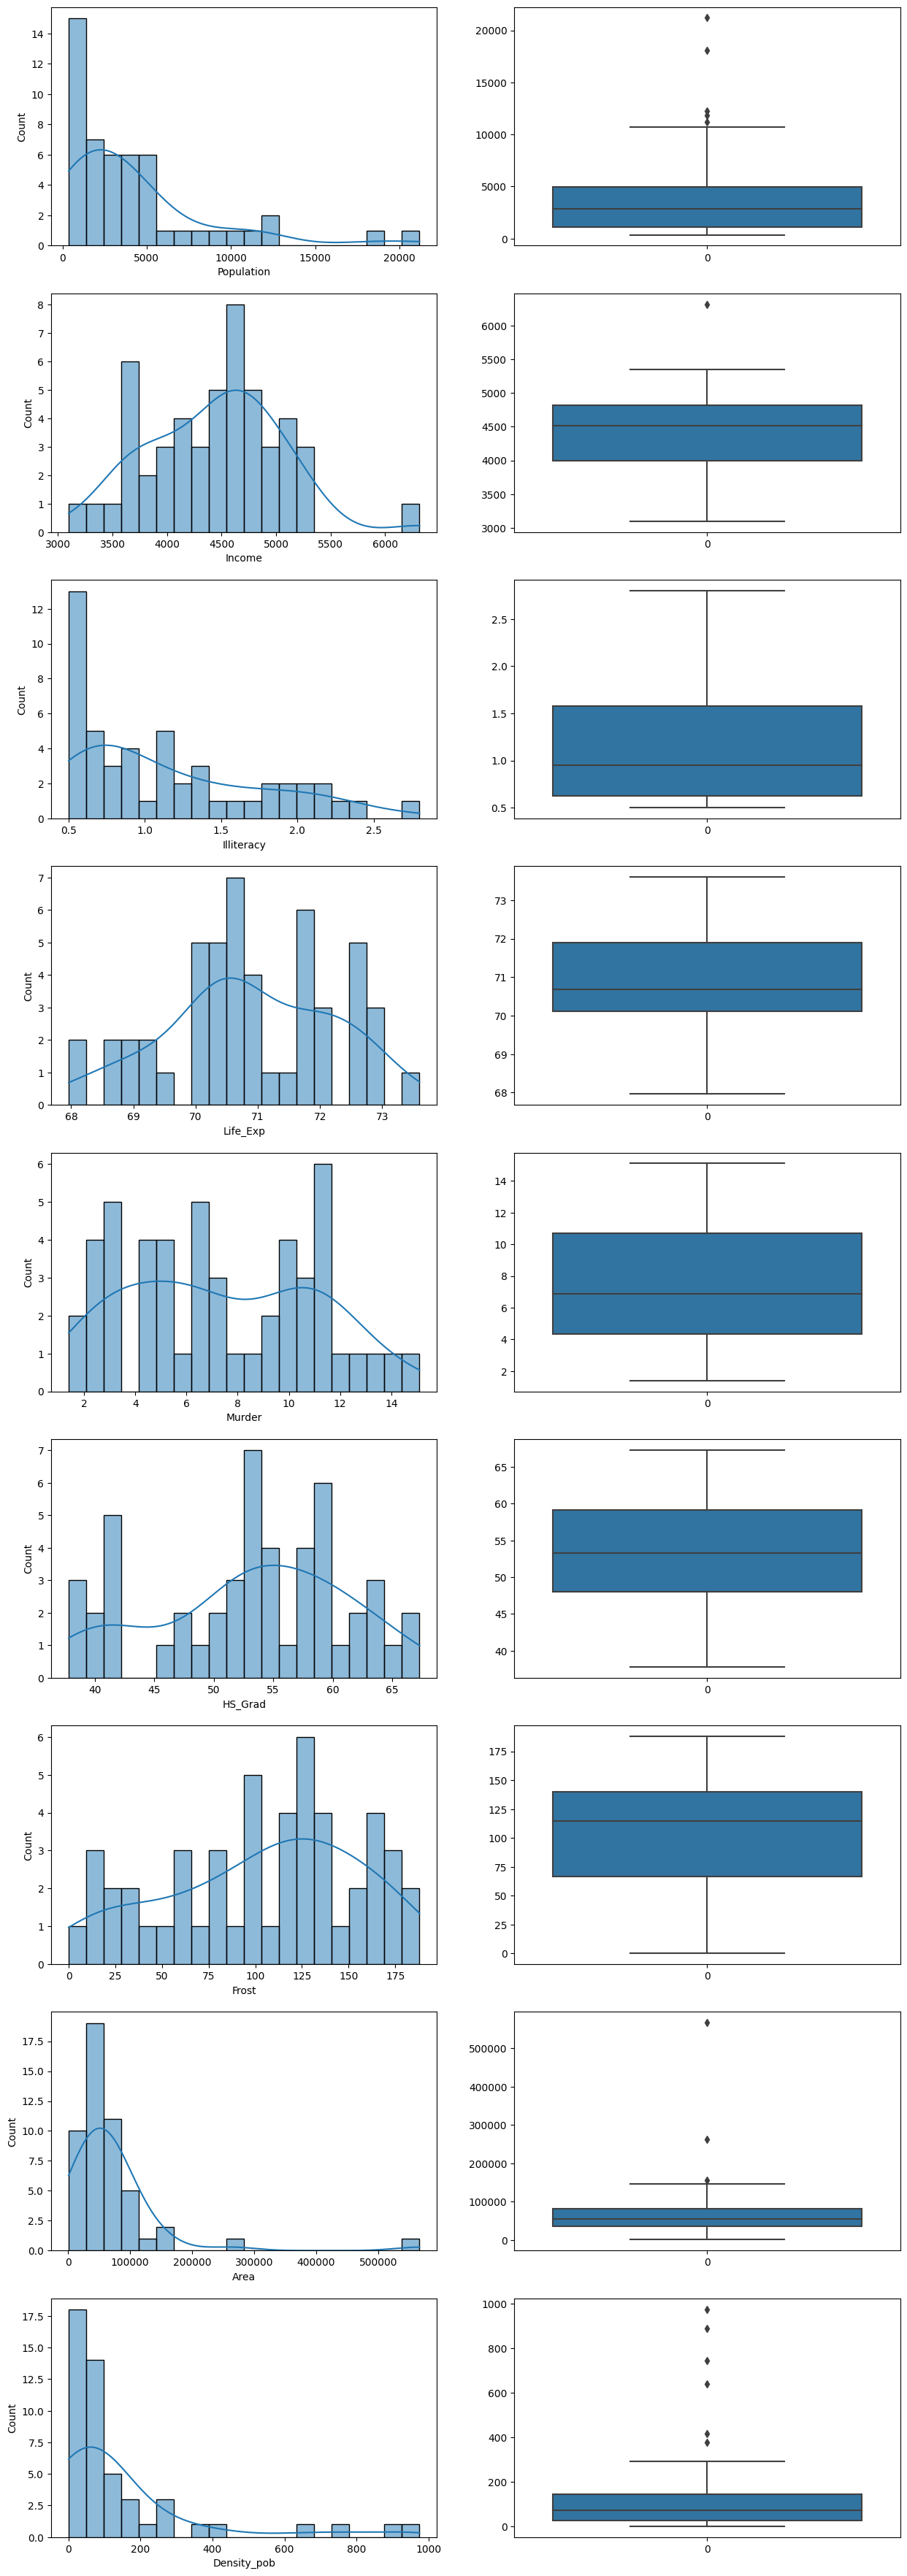

In [156]:
fig, axs = plt.subplots(9, 2, figsize=(15, 45))

# Histogramas

sns.histplot(data=df_state, x='Population', bins=20, kde=True, ax=axs[0, 0], label='Poblacion')
sns.histplot(data=df_state, x='Income', bins=20, kde=True, ax=axs[1, 0], label='Income')
sns.histplot(data=df_state, x='Illiteracy', bins=20, kde=True, ax=axs[2, 0], label='Illiteracy')
sns.histplot(data=df_state, x='Life_Exp', bins=20, kde=True, ax=axs[3, 0], label='Life_Exp')
sns.histplot(data=df_state, x='Murder', bins=20, kde=True, ax=axs[4, 0], label='Murder')
sns.histplot(data=df_state, x='HS_Grad', bins=20, kde=True, ax=axs[5, 0], label='HS_Grad')
sns.histplot(data=df_state, x='Frost', bins=20, kde=True, ax=axs[6, 0], label='Frost')
sns.histplot(data=df_state, x='Area', bins=20, kde=True, ax=axs[7, 0], label='Area')
sns.histplot(data=df_state, x='Density_pob', bins=20, kde=True, ax=axs[8, 0], label='Density_pob')


sns.boxplot(data=df_state['Population'], ax=axs[0, 1])
sns.boxplot(data=df_state["Income"], ax=axs[1, 1])
sns.boxplot(data=df_state["Illiteracy"], ax=axs[2, 1])
sns.boxplot(data=df_state["Life_Exp"], ax=axs[3, 1])
sns.boxplot(data=df_state["Murder"], ax=axs[4, 1])
sns.boxplot(data=df_state["HS_Grad"], ax=axs[5, 1])
sns.boxplot(data=df_state["Frost"], ax=axs[6, 1])
sns.boxplot(data=df_state["Area"], ax=axs[7, 1])
sns.boxplot(data=df_state["Density_pob"], ax=axs[8, 1])

**Remoción de datos atípicos**

In [157]:
def remove_outliers_iqr(data):
    
    # Calculate the first quartile (Q1) and third quartile (Q3)
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    
    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1
    
    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Remove outliers
    data = np.where(data>upper_bound, upper_bound, np.where(data<lower_bound,lower_bound,data))
    return data[(data >= lower_bound) & (data <= upper_bound)]

In [158]:
for i in df_state.columns:
    df_state[i] = remove_outliers_iqr(df_state[i])

In [172]:
df_state_test = df_state

### **Análisis de regresión**

**1. Variables**:

**Explicada (Y)**: Life_Exp

**Explicatorias (Xi)**: Population, Incom, Illiteracy, Life_Exp, Murder, HS_Grad, Frost, Area, Density_pob
____

**2. Relación entre las variables:**

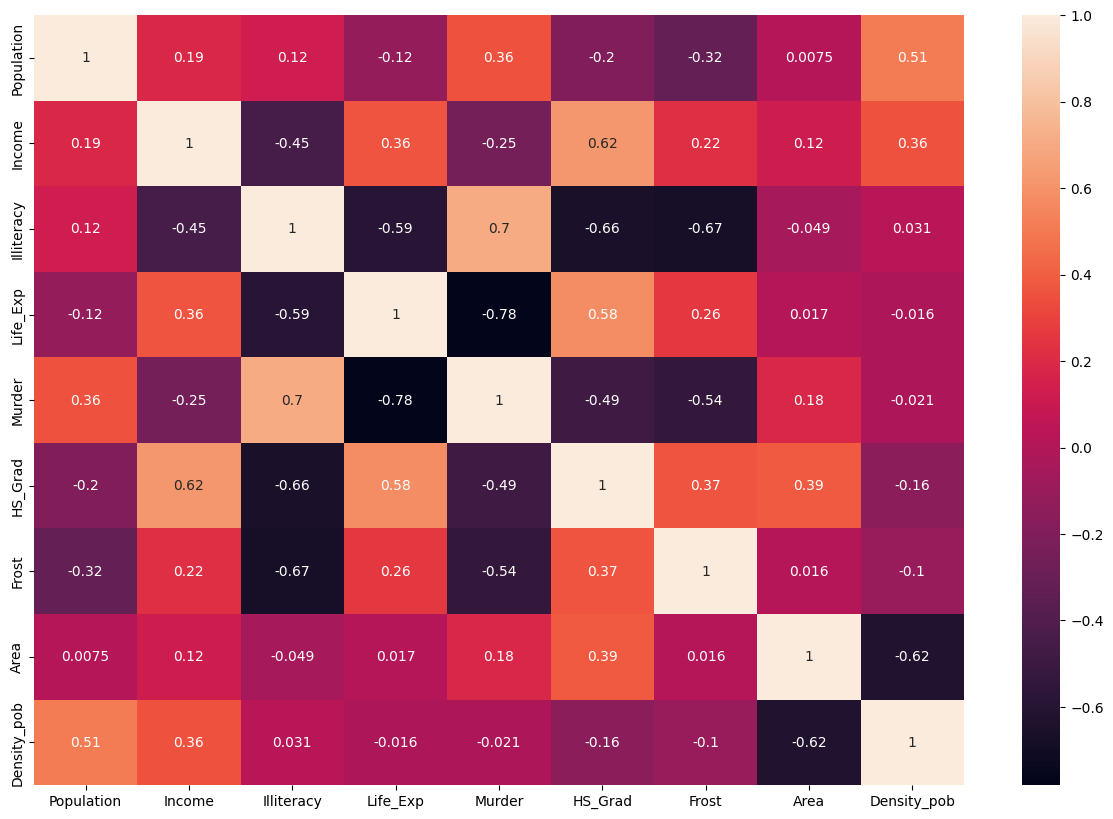

In [160]:
plt.figure(figsize=(15,10))
sns.heatmap(df_state_test.corr(),fmt='.2g',annot=True)
plt.show()

> El primer y mas evidente dato a remarcar es el de el asesinato, ya que tiene una fuerte correlación inversa con la esperanza de vida, este dato no se retira porque no incumple con la independencia del resto de datos.

> Decidimos retirar las columnas de Area y Población, ya que la densidad de población reune los dos valores.

> Retiramos analfabetismo y HS_Grad debido a su fuerte correlacion entre si mismas y el income. 

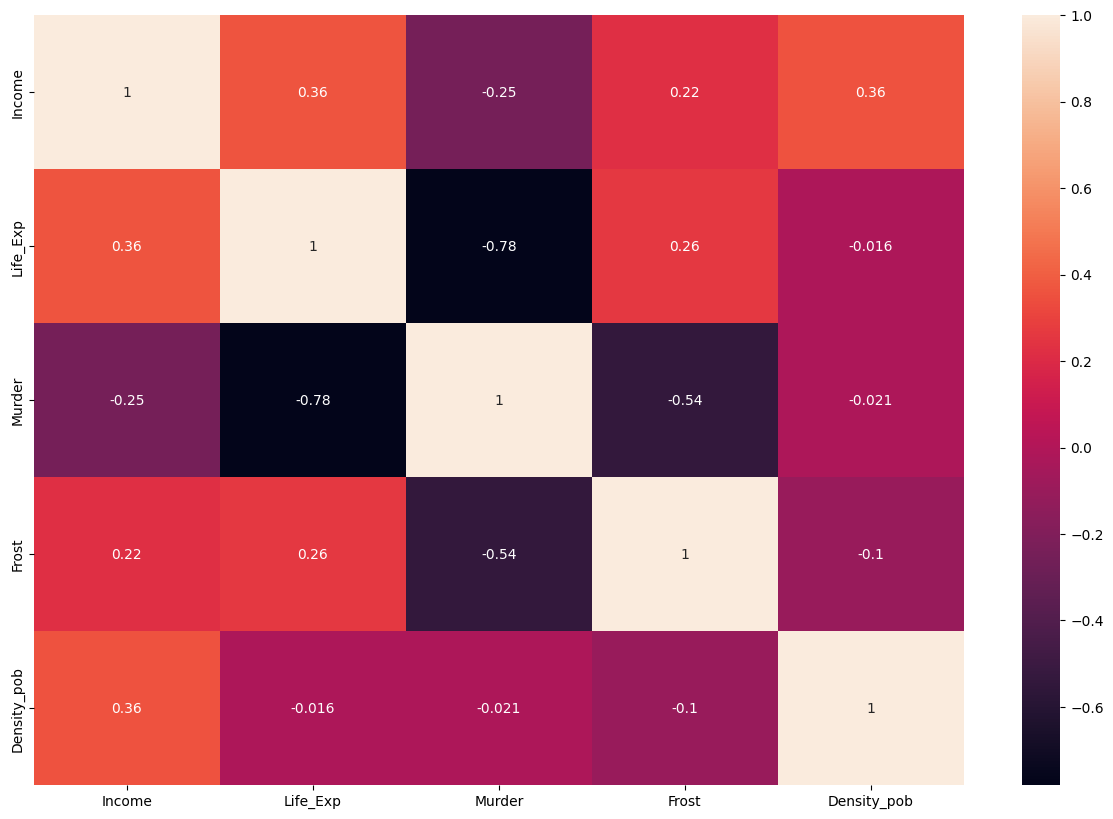

In [161]:
df_state_test = df_state_test.drop(['Population', 'Area', 'HS_Grad', 'Illiteracy'], axis=1)
plt.figure(figsize=(15,10))
sns.heatmap(df_state_test.corr(),fmt='.2g',annot=True)
plt.show()

Text(0, 0.5, 'Expectativa de vida')

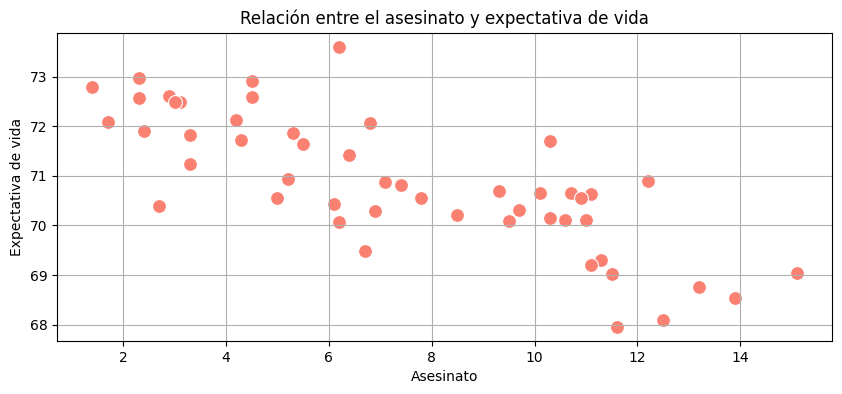

In [162]:
plt.figure(figsize = (10, 4))
plt.grid(True)
sns.scatterplot(x = 'Murder', y = 'Life_Exp', s = 100, data = df_state_test, color='salmon')
plt.title('Relación entre el asesinato y expectativa de vida')
plt.xlabel('Asesinato')
plt.ylabel('Expectativa de vida')

### **Generacion de modelo**

In [163]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [164]:
x = df_state_test.drop(columns= ['Life_Exp'])
y = df_state_test['Life_Exp']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.3, random_state= 42)

In [165]:
#Calculamos el intercepto con el eje y para los datos de entrenamiento
x_train_sm = sm.add_constant(x_train)

#Ajustamos el modelo
lr = sm.OLS(y_train, x_train_sm).fit()

#Calculamos el intercepto con el eje y de los datos de prueba
x_test_sm = sm.add_constant(x_test)

# Predecir los valores de y correspondientes a los valores de x_test_sm
y_pred_test = lr.predict(x_test_sm)
y_pred_train = lr.predict(x_train_sm)

In [166]:
print(lr.params)
print(lr.summary())

const          71.692443
Income          0.000518
Murder         -0.301195
Frost          -0.006632
Density_pob    -0.001445
dtype: float64
                            OLS Regression Results                            
Dep. Variable:               Life_Exp   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     15.77
Date:                Thu, 02 Nov 2023   Prob (F-statistic):           4.70e-07
Time:                        00:58:10   Log-Likelihood:                -40.066
No. Observations:                  35   AIC:                             90.13
Df Residuals:                      30   BIC:                             97.91
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025   

Si tomamos un nivel de significancia de 0.05, entonces los únicos datos significantes serían los asesinatos y las heladas.

Luego la ecuación de la recta que mejor se ajusta a nuestros datos es:
________________________________________________________________________

                Y = -0.3012 *Murder - 0.0066 *Frost + 71,6924
________________________________________________________________________

**Interpretación**

La pendiente nos da información sobre la taza de cambio entre los asesinatos, las heladas y la expectativa de vida.

Las estimaciones de la tabla nos dicen que por cada aumento del 0.7% en la cantidad de asesinatos hay una disminución asociada del 30% en la expectativa de vida, y que por cada aumento del 1% en la cantidad de heladas hay una disminución asociada del 0.7% en la expectativa de vida.

**Validación de supuestos**

**Supuesto 1: Variable dependiente normal**

H_0 : El porcentaje de incidencia de enfermedades cardiacas sigue una distribución normal

H_1 : El porcentaje de incidencia de enfermedades cardiacas no sigue una distribución normal

In [168]:
from scipy import stats
ks_statistic, ks_p_value = stats.kstest(df_state_test['Life_Exp'], 'norm', args=(df_state_test['Life_Exp'].mean(), df_state_test['Life_Exp'].std()))

# Imprimir el resultado
print(f'Estadístico de prueba W: {ks_statistic:.4f}')
print(f'P-valor: {ks_p_value:.4f}')

# Interpretar el resultado
alfa = 0.05  # Nivel de significancia
if ks_p_value > alfa:
    print('No se rechaza la hipótesis nula. Los datos siguen una distribución normal.')
else:
    print('Se rechaza la hipótesis nula. Los datos no siguen una distribución normal.')

Estadístico de prueba W: 0.0910
P-valor: 0.7681
No se rechaza la hipótesis nula. Los datos siguen una distribución normal.


**Supuesto 2: Homoscedasticidad de los residuales**

H_0 : Homoscedasticidad en los residuales

H_1 : Heteroscedasticidad en los residuales

La prueba de Breush-Pagan es la más utilizada en estos casos.

In [169]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Debemos calcular los residuales (error)
residuales = lr.resid

#Realizar el test de Breusch-Pagan
_, p_value, _, _ = het_breuschpagan(residuales, x_train_sm)

# Paso 4: Imprimir los resultados
alpha = 0.05  # Nivel de significancia
print(f'P-valor: {p_value}')
if p_value < alpha:
    print('Rechazamos H0: Hay evidencia de heteroscedasticidad en los residuales')
else:
    print('No rechazamos H0: No hay evidencia suficiente para afirmar heteroscedasticidad en los residuales')

P-valor: 0.6147779137149164
No rechazamos H0: No hay evidencia suficiente para afirmar heteroscedasticidad en los residuales


**Supuesto 3: Normalidad de los residuos**

**H_0** : Los residuos siguen una distribución normal

**H_1** : Los residuos no siguen una distribución normal

In [170]:
from scipy import stats
# Realizar la prueba de Shapiro-Wilk
ks_statistic, ks_p_value = stats.kstest(residuales, 'norm', args=(residuales.mean(), residuales.std()))

# Imprimir el resultado
print(f'Estadístico de prueba W: {ks_statistic:.4f}')
print(f'P-valor: {ks_p_value:.4f}')

# Interpretar el resultado
alfa = 0.05  # Nivel de significancia
if ks_p_value > alfa:
    print('No se rechaza la hipótesis nula. Los datos siguen una distribución normal.')
else:
    print('Se rechaza la hipótesis nula. Los datos no siguen una distribución normal.')

Estadístico de prueba W: 0.1055
P-valor: 0.7928
No se rechaza la hipótesis nula. Los datos siguen una distribución normal.


**Supuesto 4: No autocorrelación: residuos independientes**

**H_0** : Independencia en los residuales

**H_1** : No independencia en los residuales

In [171]:
from statsmodels.stats.diagnostic import acorr_ljungbox

alpha = 0.05
# Realizar la prueba de Ljung-Box
resultado = acorr_ljungbox(residuales,lags=[10])
if float(resultado['lb_pvalue']) > alpha:
    print("No se rechaza la hipotesis nula, Independencia en los residuales")
else:
    print("Se rechaza la hipotesis nula, No hay independencia en los residuales")

No se rechaza la hipotesis nula, Independencia en los residuales


### **Conclusiones**
- Despues de un  estudio a los datos por medio de graficas, decidimos remover los valores atipicos, esto con la finalidad de que no estropeen el aprendizaje del modelo posteriormente.
- Para filtrar las columnas que nos serviran en el modelo de aprendizaje automatico realizamos un mapa de calor(Matriz de covarianza); obtuvimos que varias columnas como por ejemplo area y poblacion estan altamente correlacionadas con densidad de poblacion, en este ejempo nos quedamos con densidad de poblacion porque es una columna que representa las dos anteriormente mencionadas. Basandonos en el mismo principio hicimos el ejercicio con las demas columnas buscando que exista una independencia entre las columnas. Tambien realizamos un grafico de dispersion(murder vs Life_exp) para observar graficamente si seguian una relacion lineal, la cual observamos que lo hacian.
- Se vio un numero reducido de columnas que presentaran significancia estadistica para el modelo de prediccion, se sabe que la relacion entre los asesinatos y la esperanza de vida es facilmente interpretable ya que esta acaba con la vida. Respecto a las heladas podemos decir que afecta directamente la salud de la poblacion.